In [4]:
import os
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K

import matplotlib.pyplot as plt
import PIL.Image as Image

from data import load_train_data, load_test_data

K.set_image_data_format('channels_last')  # TF dimension ordering in this code

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Basically here we can see vanilla `U-Net` with some minor changes: 

- different input image size: `(96, 96)` instead of `(572, 572)`;
- different number of filters - reduced by 2 (32 instead of 64 in the first conv. block etc.);

There are a few questions:
    
- why do we concatenate layers;
- how does `Conv2DTranspose` work exactly;
- why do we use (1, 1) convolution;

We have also the following questions:
    
- why do we use such low learning rate (`lr=1e-5`);
- why do we use custom loss function instead based on dice coefficient;

## dice coefficient

### mask values

First of all let's see what values we have in a mask. We may see that we have only 0 and 255.

In [2]:
imgs_train, imgs_mask_train = load_train_data()

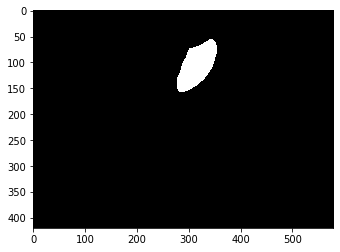

In [5]:
plt.imshow(imgs_mask_train[4], cmap='gray');

In [6]:
mask = imgs_mask_train[4]

In [7]:
mask_arr = np.array(mask)

In [8]:
mask_arr.shape

(420, 580)

In [9]:
mask_arr[:3, :3]

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]], dtype=uint8)

In [11]:
mask_arr[100:103, 300:303]

array([[255, 255, 255],
       [255, 255, 255],
       [255, 255, 255]], dtype=uint8)

### definition of the coefficient

Definition is quite easy - for 2 sets $X$ and $Y$:

$$DC = \frac{2 |X \cap Y|}{|X| + |Y|}$$

The issue that the intersection is implemented as `intersection = K.sum(y_true_f * y_pred_f)`. Suppose we have only 0s and 1s in our arrays then we actually count intersection of 1s (not 0s). 

Looks like we can apply this definition if we count intersection of 1s and sum of 1s. In this case we can compute it like this:

$$DC = \frac{2X \cdot Y}{sum(X) + sum(Y)}$$

The next question - what is the difference betwen $DC$ and $F1$ score? It looks like there's no difference:

$$F1 = \frac{2TP}{2TP + FP + FN}$$

So we can say that $TP$ is an intersection of 1s and that's exactly what we have in $DC$ and so on.

Finally we can say that it's a better metric in our case than accuracy given how much 0s (black color) do we have in masks.

## data processing (yet again)

In [12]:
imgs_train, imgs_mask_train = load_train_data()

In [13]:
imgs_train.shape

(5635, 420, 580)

In [14]:
img_arr = imgs_train[0]

In [15]:
type(img_arr)

numpy.ndarray

In [16]:
img_arr[:3, :3]

array([[  0,  63,  58],
       [  0,  99,  73],
       [  0, 126, 112]], dtype=uint8)